In [1]:
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option("display.max_columns", None) # 表示する列数の制限を解除

In [2]:
with open(r"C:\Users\yasak\デスクトップ\Keiba_App\mykeibaAI_ver1p0\data\merged_table.pkl", "rb") as f:
    # "C:\Users\yasak\デスクトップ\Keiba_App\mykeibaAI_ver1p0\data\merged_table.pkl" # NotePC用フォルダパス
    # "C:\\Users\\yasak\\Desktop\\mykeibaAI\\data\\merged_table.pkl" # Desktop用フォルダパス
    model = pickle.load(f)

print(model.columns)
print(f"Number of items: {len(model.columns)}")
print(f"Number of rows: {len(model)}")

Index(['date', 'race_id', 'is_win', 'rank', 'horse_id', 'weight_carried',
       'jockey_id', 'popularity', 'odds', 'last3f', 'trainer_id',
       'body_weight', 'sex', 'age', 'time_sec', 'body_diff', 'weather',
       'course_condition', 'course_state', 'distance_length', 'log_odds',
       'log_odds_avg_3', 'log_odds_avg_5', 'log_odds_avg_10',
       'odds_zscore_in_race'],
      dtype='object')
Number of items: 25
Number of rows: 28506


In [3]:
feature = [
    'weight_carried',
    'popularity',
    'odds',
    'last3f',
    'body_weight',
    'sex',
    'age',
    'time_sec',
    'body_diff',
    'weather',
    'course_condition',
    'course_state',
    'distance_length',
    'log_odds',
    'log_odds_avg_3',
    'log_odds_avg_5',
    'log_odds_avg_10',
    'odds_zscore_in_race',
    ]
X = model[feature]
y = model['is_win']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [5]:
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

In [6]:
ml_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], valid_names=['train', 'eval'])
y_pred_prob = ml_model.predict(X_test, num_iteration=ml_model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int) # 確率を0.5で閾値判定
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

results = X_test.copy() # 学習データ
results["actual"] = y_test # 実際の予測対象
results["predicted"] = y_pred # 予測結果
results["predicted_prob"] = y_pred_prob # 予測確率

results.head(10)

Accuracy: 92.90%


,weight_carried,popularity,odds,last3f,body_weight,sex,age,time_sec,body_diff,weather,course_condition,course_state,distance_length,log_odds,log_odds_avg_3,log_odds_avg_5,log_odds_avg_10,odds_zscore_in_race,actual,predicted,predicted_prob
21107,57.0,12.0,110.6,41.0,446.0,0,3.0,89.2,-2.0,1.0,0.0,1,1400,4.705920,3.825416,4.034857,NaN,-0.111187,0,0,0.002168
17038,55.0,3.0,6.5,42.0,472.0,1,3.0,117.8,-8.0,1.0,0.0,1,1800,1.871802,4.094987,NaN,NaN,-0.810569,0,0,0.001465
2281,54.0,7.0,73.5,35.9,466.0,1,3.0,120.9,8.0,1.0,0.0,0,2000,4.297285,NaN,NaN,NaN,2.352439,0,0,0.006831
3378,58.0,1.0,3.0,38.6,496.0,2,5.0,112.7,2.0,0.0,0.0,1,1800,1.098612,NaN,NaN,NaN,-1.134776,0,0,0.195258
19085,56.0,9.0,45.2,37.0,480.0,2,6.0,110.4,-6.0,0.0,2.0,0,1800,3.811097,NaN,NaN,NaN,-0.213734,0,0,0.014093
13174,57.0,11.0,35.6,39.2,464.0,0,4.0,115.3,8.0,1.0,0.0,1,1800,3.572346,NaN,NaN,NaN,-0.421186,0,0,0.007596
4404,56.0,2.0,3.6,39.7,462.0,0,2.0,88.1,-2.0,0.0,0.0,1,1400,1.280934,NaN,NaN,NaN,-0.778585,0,0,0.020222
28181,51.0,11.0,42.0,40.8,412.0,1,3.0,75.1,-14.0,0.0,0.0,1,1200,3.737670,NaN,NaN,NaN,-0.200667,0,0,0.002520
16441,57.0,2.0,3.1,34.3,444.0,0,3.0,94.3,4.0,1.0,0.0,0,1600,1.131402,3.122717,2.898839,NaN,-1.001423,0,0,0.300581
14118,58.0,7.0,27.2,38.9,522.0,0,5.0,113.7,10.0,1.0,NaN,1,1800,3.303217,3.198344,NaN,NaN,-0.261300,0,0,0.008334


In [7]:
print(f"Actual values:\n{results['actual'].value_counts()}")
print(f"Predicted values:\n{results['predicted'].value_counts()}")

Actual values:
actual
0    5283
1     419
Name: count, dtype: int64
Predicted values:
predicted
0    5634
1      68
Name: count, dtype: int64


### SHAPを使った分析

In [8]:
import shap
import matplotlib.pyplot as plt

c:\Users\yasak\デスクトップ\Keiba_App\mykeibaAI_ver1p0\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\yasak\デスクトップ\Keiba_App\mykeibaAI_ver1p0\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\yasak\デスクトップ\Keiba_App\mykeibaAI_ver1p0\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


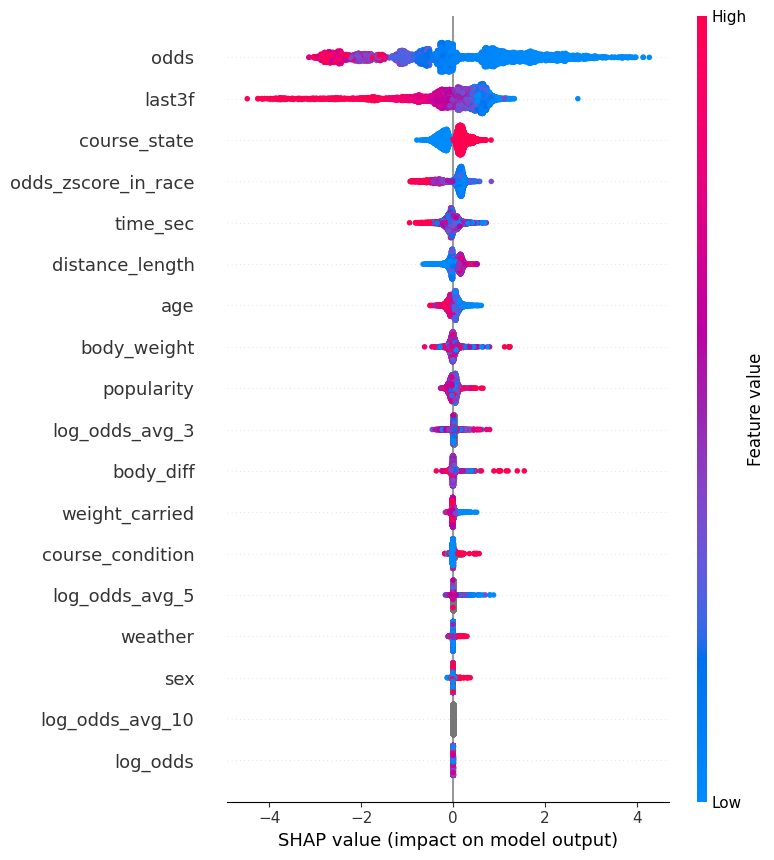

In [9]:
explainer = shap.TreeExplainer(ml_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

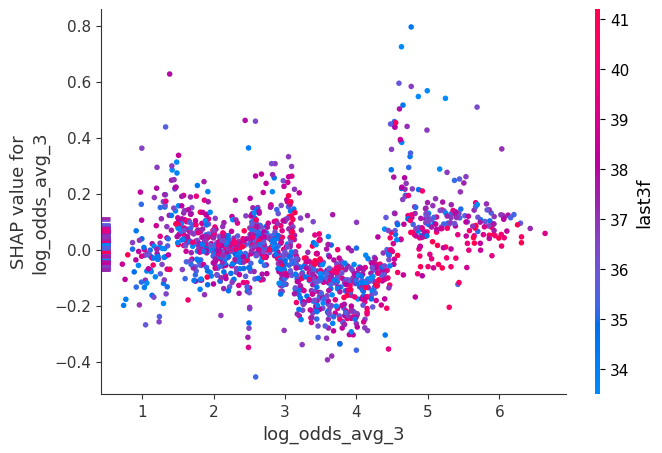

In [11]:
# 例：log_odds_avg_3 の依存プロット（色は last3f）
shap.dependence_plot("log_odds_avg_3", shap_values, X_test, interaction_index="last3f")

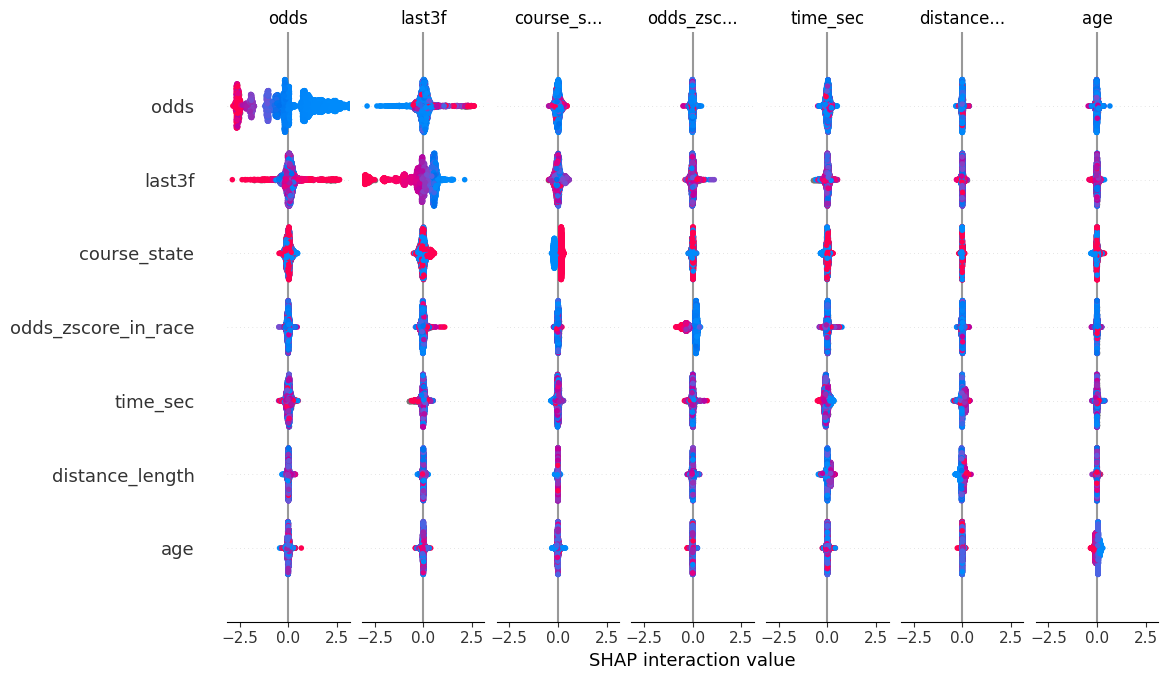

In [12]:
# SHAP interaction values を計算（時間がかかる）
interaction_values = explainer.shap_interaction_values(X_test)

# 例：odds × last3f の交互作用プロット
shap.summary_plot(interaction_values, X_test)

### ランキング学習

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
params_rank = {
    'objective': 'lambdarank', # ランキング学習
    'metric': 'ndcg', # 評価指標(NDCG)
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}